# ASP 3231 Project: NGC 3293
## Flat Image Combine - Cedric Liang

Here I will be combining the flat images in order to produce a median combined flat image. Let's first make our imports:

In [31]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gc
gc.enable()
import os
import warnings

warnings.filterwarnings('ignore')                                       #ignore warnings
root_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)          # set root directory of repo

Next, let's read our flat image files into Python based on their filename. We'll then take these filenames and generate a dictionary of our raw flat images.

In [32]:
# open my flat files and assign them to their band with a bit of comprehension syntax
flat_files = {band: ccdproc.ImageFileCollection(
    f"{root_path}/data/", glob_include=f"Flat_{band}*") for band in ["V", "B", "R"]}

flats = {
    band: [CCDData.read(f"{root_path}/data/{fn}", unit="adu")
           for fn in image_files.files]
    for band, image_files
    in flat_files.items()}

We'll define a function for returning stats that can be reused and called easily whenever we need a sanity check about whether our processes are working:

In [33]:
# function to return a dict of flat stats, given an image
def image_stats(image):
    return {
        'Min': np.min(image),
        'Max': np.max(image),
        'Mean': np.mean(image),
        'Mdn': np.median(image),
        'Stdev': np.std(image)
    }

#A function that prints the stats, given a dict of image stats. Keeping these separate allows us to take the stats as variables if we need to use it programatically.
def print_stats(label: str, stats_dict):
    print("\n", label)
    for key, value in stats_dict.items():
        print("\t", key, "\t\t", value)

In [34]:
#print the stats for the first image in each band for a sanity check
for band in ["V", "B", "R"]:
    print_stats(f"{band} stats: ", image_stats(flats[band][0]))


 V stats: 
	 Min 		 17068
	 Max 		 24721
	 Mean 		 22925.218607293875
	 Mdn 		 23087.0
	 Stdev 		 706.5667311365166

 B stats: 
	 Min 		 13175
	 Max 		 22332
	 Mean 		 20489.062079866442
	 Mdn 		 20625.0
	 Stdev 		 694.877838329988

 R stats: 
	 Min 		 6613
	 Max 		 16822
	 Mean 		 14905.913510842063
	 Mdn 		 15013.0
	 Stdev 		 550.4310847257935


Here, our stats show that there is clearly a difference in the background for each flat. That's because they were taken successively in the twilight hours where photon counts were decreasing over time, and as such we'll need to normalise.

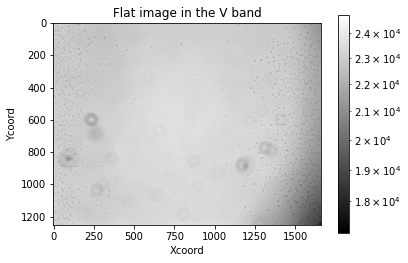

In [35]:
plt.imshow(flats["V"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the V band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 1: Sample dark image in the V band, with a lognorm scaled applied to pixel counts. Note the structural features - vignetting in the corners, large donuts, as well as smaller specks of dust on the glass.

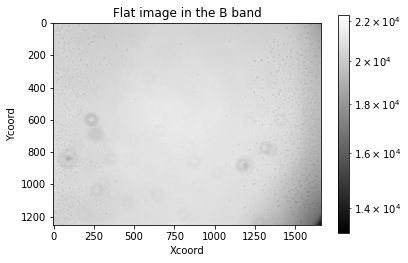

In [36]:
plt.imshow(flats["B"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the B band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 2: Sample dark image in the B band, with a lognorm scaled applied to pixel counts. The structural features are similar, indicating that the dust is on the telescope rather than the filters.

Now we'll need to process flat images using the bias and dark images. Let's first subtract the bias.

In [37]:
# Import the bias
bias_median = CCDData.read(f"{root_path}/src/bias_median.fits")

print_stats("Bias median stats: ", image_stats(bias_median))


 Bias median stats: 
	 Min 		 2048.5
	 Max 		 2233.0
	 Mean 		 2082.5105
	 Mdn 		 2079.0
	 Stdev 		 14.54244327545166


These values look about right! Let's subtract them.

In [42]:
flats_min_bias = {band:[ccdproc.subtract_bias(image, bias_median) for image in band_flats_array] for band, band_flats_array in flats.items()}

In [43]:
print_stats("Vband Flats sub bias first image stats: ", image_stats(flats_min_bias["V"][0]))


 Vband Flats sub bias first image stats: 
	 Min 		 14926.0
	 Max 		 22641.0
	 Mean 		 20842.707859847575
	 Mdn 		 21006.5
	 Stdev 		 713.6295616987921


Note that our mean and medians have dropped by about 2000. This looks good! Now let's subtract our darks. First, we'll generate the darks with a median combine:

In [44]:
dark_median = CCDData.read(f"{root_path}/src/dark_median.fits")

print_stats("Dark median stats: ", image_stats(dark_median))


 Dark median stats: 
	 Min 		 35.0
	 Max 		 63459.5
	 Mean 		 231.15259
	 Mdn 		 193.0
	 Stdev 		 671.94189453125


In [11]:
flats_min_dark = {band:
                    [ccdproc.subtract_dark(image, dark_median, 
                                                    exposure_time = 'EXPTIME', 
                                                    exposure_unit=u.second, 
                                                    scale=True) 
                        for image in image_array] 
                    for band, image_array in flats_min_bias.items()}

In [45]:
print_stats("Vband Flats min dark first image: ", image_stats(flats_min_dark["V"][0]))


 Vband Flats min dark first image: 
	 Min 		 14925.950277775526
	 Max 		 22640.945000000298
	 Mean 		 20842.643650787108
	 Mdn 		 21006.449583332986
	 Stdev 		 713.6305959848572


Here, our darks have been subtracted. They haven't affected the pixel counts too much because their counts are being scaled down from the hourlong exposure duration, but the values look right.

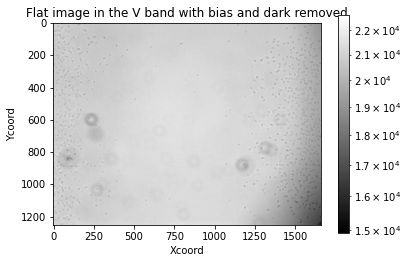

In [46]:
plt.imshow(flats_min_dark["V"][0], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Flat image in the V band with bias and dark removed")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 3: Our bias and dark removed flat image. Looks pretty similar to the previous images, as they should.

Finally, let's renormalise these flats and combine them.

In [47]:
# dict to hold results
flat_medians = {}

for band, sub_flats in flats_min_dark.items():              # iterative over subtracted flats
    tempimages = sub_flats.copy()
    
    for idx, image in enumerate(tempimages):                # produce median for each image
        m = 1.0 / np.ma.median(image)
        tempimages[idx] = image.multiply(m * u.adu)         # multiply by median for each image
    
    flat_medians[band] = ccdproc.Combiner(
        tempimages, dtype=np.float32).median_combine()

In [48]:
for key, value in image_stats(flat_medians["V"][0]).items():
    print(key, value)

Min 0.9049362
Max 1.014467
Mean 0.9897254
Mdn 0.9946958422660828
Stdev 0.018294747918844223


Here, we have a reasonable set of values for renormalised and median combined flats! We expect these values to be close to 1 because each pixel is a multiplicative offset from the median, and as such should be closed to 1.

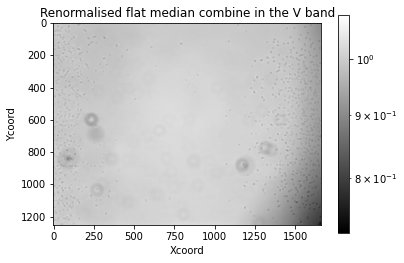

In [49]:
plt.imshow(flat_medians["V"], cmap='gray', norm=LogNorm())
plt.colorbar()
plt.title("Renormalised flat median combine in the V band")
plt.xlabel("Xcoord")
plt.ylabel("Ycoord")
plt.show()

<font color="Blue"> Figure 4: We've performed the median combine of the flats, and renormalised. This has generated our structural elements in the image.

Our final result for the renormalised flats indeed seem to have served their purpose - identified the structural abberations in our observations. We're now happy enough with this to write it to file, with which we can process the science images.

In [50]:
for band, flat_median in flat_medians.items():
    flat_median.meta.update(EXPTIME=1)
    flat_median.meta.update(TELESCOP='C11')
    flat_median.meta.update(OBJECT=f"Flat_{band}_Median")
    flat_median.write(f"Flat_{band}_median.fits", overwrite=True)

In [51]:
del(flats)
del(tempimages)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 29398
